In [1]:
cd ../katya

/home/jovyan/katya


In [6]:
import os, json
from collections import defaultdict
import glob
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

class ResultAggregator():
    def __init__(self, result_path, model_name=None,
                heatmap_name="results_heatmap",
                csv_name="results"):
        self.result_path = result_path
        self.SCORES = []
        self.heatmap_name = heatmap_name
        self.csv_name = csv_name
        
    def collect_scores(self):
        # small bloom results
        #results = glob.glob("protasov/Probing_framework/results/experiment_2022_09_04-12:14:05_AM")
        # big bloom results
        results = glob.glob(self.result_path)
        params = defaultdict(set)
        for experiment in results:
            for base_folder, folders, files in os.walk(experiment):
                if files and files != ["aggreg_res.ipynb"]:
                    for file in files:
                        dat = json.load(open(f"{base_folder}/{file}"))
                        num_examples = sum([sum(el.values()) for el in dat["params"]["original_classes_ratio"].values()])
                        ratio = list(dat["params"]["original_classes_ratio"]["te"].items())
                        for k, v in dat["params"].items():
                            if type(v) is str: params[k].add(v)

                        xs = list(dat["results"]["test_score"].keys())
                        ys_f1 = [element[0] for element in dat["results"]["test_score"]["f1"].values()]
                        ys_acc = [element[0] for element in dat["results"]["test_score"]["accuracy"].values()]
                        ys_cr = [element[0] for element in dat["results"]["test_score"]["classification_report"].values()]
                        score = dat["params"].copy()
                        score["num_labels"] = len(score["tr_mapped_labels"])
                        score["coord"] = xs
                        score["f1"] = ys_f1
                        score["classification_report"] = ys_cr
                        #score["classification_report"] = []
                        score["accuracy"] = ys_acc
                        score["num_examples"] = num_examples
                        score["ratio"] = ratio
                        self.SCORES.append(score)

        return None
            
    
    def make_df(self):
        scores = pd.json_normalize(self.SCORES)
        scores = scores[['probing_task', 'hf_model_name', 'task_language', 'task_category', 
                         'coord', 'f1', 'accuracy', 'num_labels', 'num_examples', 'ratio', 'classification_report']]
        
        scores["f1_avg"] = scores["f1"].apply(lambda x: sum(x)/len(x))
        scores["acc_avg"] = scores["accuracy"].apply(lambda x: sum(x)/len(x))
       # std_scores = scores.groupby(["probing_task",
       #                              "hf_model_name", "task_category"])["f1_avg"].std().reset_index()
       # mean_scores = scores.groupby(["probing_task", 
       #                          "hf_model_name", "task_category"]).mean().reset_index()
       # scores = pd.merge(scores, mean_scores, on=["task_category", "probing_task", "hf_model_name"])
       # scores = scores[['probing_task', 'hf_model_name', 'task_language', 'task_category',
       #    'coord', 'f1', 'accuracy', 'num_labels_x', 'ratio', 'f1_avg_x', 'acc_avg_x',
       #    'num_examples_y', 'f1_avg_y', 'acc_avg_y', 'classification_report']]
       # scores = pd.merge(scores, std_scores, on=["task_category", "probing_task", "hf_model_name"])
       # scores.columns = ['probing_task', 'hf_model_name', 'task_language', 'task_category',
       #'coord', 'f1', 'accuracy', 'num_labels', 'ratio', 'f1_avg', 'acc_avg_mean', 'num_examples', 'f1_avg_mean',
       #'acc_avg_mean', 'f1_std', 'classification_report']
        return scores
    
    def calculate_selectivity(self, df):
        df["control_task"] = 0
        for num, test_string in df.iloc[3::4, :].iterrows():
           # if "selectivity" in test_string["probing_task"]:
               # task_name = test_string["probing_task"].split("_selectivity")[0]
            df.loc[df.probing_task == test_string["probing_task"], "control_task"] = test_string["f1_avg"]

        #df = df[df["probing_task"].apply(lambda x: "selectivity" not in x)]
        #df = df[df.index % 4 != 0] 
        df["selectivity"] = df["f1_avg"] - df["control_task"]
        return df
    
    def save_results(self, scores):
        scores.to_csv(f"{self.csv_name}.csv")
        
       # scores_by_lang = scores.groupby("family").mean().reset_index()
       # scores_by_lang.to_csv(f"{self.csv_name}_by_family.csv")
        
        scores_by_cat = scores.groupby("task_category").mean().reset_index()
        scores_by_cat.to_csv(f"{self.csv_name}_by_cat.csv")
    
    def draw_heatmap(self, scores):
        scores_df = scores[["task_category", "language", "f1_avg", "hf_model_name"]]
        scores_df = scores_df.groupby(["language", "task_category"]).mean().reset_index()
        cat_name = dict(
            filter(lambda x: x[1] >= 5, scores_df.groupby('task_category').count()['language'].to_dict().items())
        )

        scores_df = scores_df[scores_df['task_category'].isin(cat_name)]
        piv = scores_df.drop_duplicates(["language", "task_category"]).pivot(columns="language", index="task_category")
        piv = piv.sort_values(by="task_category").sort_values(axis='columns', by='language')
        #piv["portion_of_nas"] = piv.apply(lambda row: len([el for el in row.tolist() if pd.isna(el)])/len(row.tolist()), axis=1)
        colscores = map(lambda colname: len([el for el in piv[colname].tolist() if pd.isna(el)])/len(piv[colname].tolist()), piv.columns)
        col2score = zip(piv.columns, colscores)
        col2score = sorted(col2score, key=lambda el: el[1])
        #piv = piv.sort_values(by="portion_of_nas")
        #piv = piv[[col for col,_ in col2score if "portion" not in col[0]]]
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        sns.heatmap(piv, ax=ax, square=True, cbar=True,cbar_kws={"shrink": .5})
        ax.set_xticklabels([f"{lang[1]}" for lang in piv.columns])
        ax.set_xlabel('Language', fontsize=20)
        ax.set_ylabel('Task category', fontsize=20)
        ax.tick_params(axis='both', labelsize=12)
        fig.savefig(f"{self.heatmap_name}.pdf", bbox_inches="tight")
    
    def aggregate(self):
        self.collect_scores()
        scores = self.make_df()
        #scores_w_selectivity = self.calculate_selectivity(scores)
        #self.save_results(scores_w_selectivity)
        #self.draw_heatmap(scores)
        return scores

In [7]:
aggregator = ResultAggregator(
    result_path="probing_results/experiment_2023_08_28*",
  #  model_name="bert-base-multilingual-cased",
    csv_name="results",
    heatmap_name="results")

scores = aggregator.aggregate()

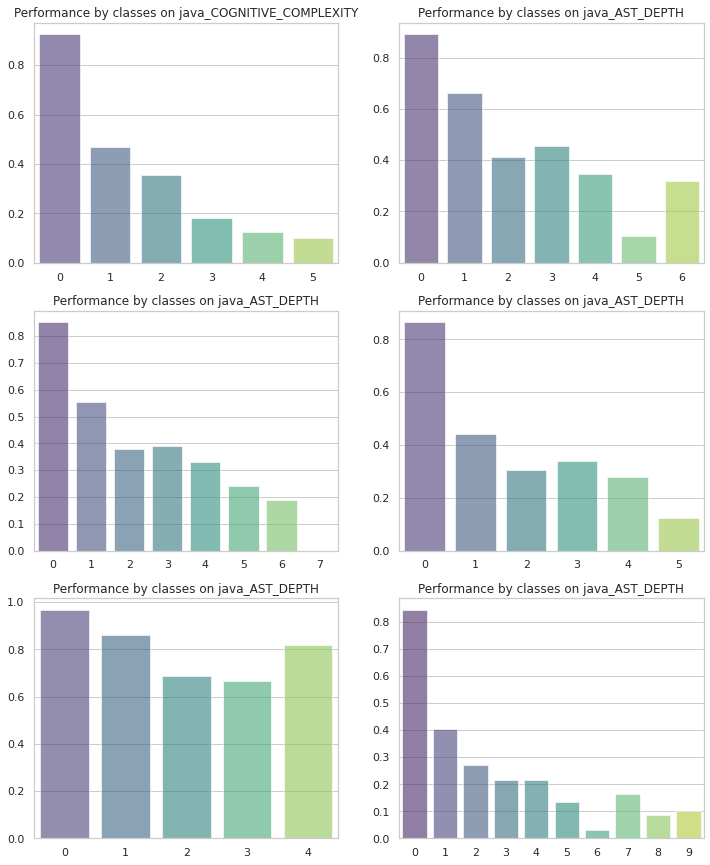

In [8]:
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(3,2, figsize=(12, 15))
# Draw a nested barplot by species and sex


f_macro = {k:v["f1-score"] for k, v in list(scores["classification_report"][0][-1].items())[:-2] if type(v) == dict}
g = sns.barplot(ax=ax[0,0], x=np.array(list(f_macro.keys())), y=np.array(list(f_macro.values())),  errorbar="sd", palette="viridis", alpha=.6)
ax[0,0].set_title(f"Performance by classes on {scores['probing_task'][0]}")

f_macro = {k:v["f1-score"] for k, v in list(scores["classification_report"][1][-1].items())[:-2] if type(v) == dict}
g = sns.barplot(ax=ax[0,1], x=np.array(list(f_macro.keys())), y=np.array(list(f_macro.values())),  errorbar="sd", palette="viridis", alpha=.6)
ax[0,1].set_title(f"Performance by classes on {scores['probing_task'][1]}")

f_macro = {k:v["f1-score"] for k, v in list(scores["classification_report"][2][-1].items())[:-2] if type(v) == dict}
g = sns.barplot(ax=ax[1,0], x=np.array(list(f_macro.keys())), y=np.array(list(f_macro.values())),  errorbar="sd", palette="viridis", alpha=.6)
ax[1,0].set_title(f"Performance by classes on {scores['probing_task'][1]}")

f_macro = {k:v["f1-score"] for k, v in list(scores["classification_report"][3][-1].items())[:-2] if type(v) == dict}
g = sns.barplot(ax=ax[1,1], x=np.array(list(f_macro.keys())), y=np.array(list(f_macro.values())),  errorbar="sd", palette="viridis", alpha=.6)
ax[1,1].set_title(f"Performance by classes on {scores['probing_task'][1]}")

f_macro = {k:v["f1-score"] for k, v in list(scores["classification_report"][4][-1].items())[:-2] if type(v) == dict}
g = sns.barplot(ax=ax[2,0], x=np.array(list(f_macro.keys())), y=np.array(list(f_macro.values())),  errorbar="sd", palette="viridis", alpha=.6)
ax[2,0].set_title(f"Performance by classes on {scores['probing_task'][1]}")

f_macro = {k:v["f1-score"] for k, v in list(scores["classification_report"][5][-1].items())[:-2] if type(v) == dict}
g = sns.barplot(ax=ax[2,1], x=np.array(list(f_macro.keys())), y=np.array(list(f_macro.values())),  errorbar="sd", palette="viridis", alpha=.6)
ax[2,1].set_title(f"Performance by classes on {scores['probing_task'][1]}")
plt.show()

In [9]:
list(zip(*f_macro))

[('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')]

In [10]:
#aggregator = ResultAggregator(
#    result_path="Probing_framework/probing_results",
  #  model_name="bert-base-multilingual-cased",
#    csv_name="results",
#    heatmap_name="results")

#scores = aggregator.aggregate()

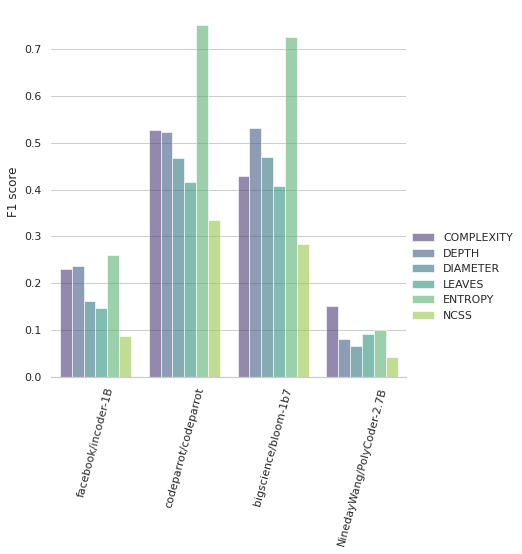

In [11]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=scores, kind="bar",
    x="hf_model_name", y="f1_avg", hue="task_category",
    errorbar="sd", palette="viridis", alpha=.6, height=6
)
g.despine(left=True)
plt.xticks(rotation = 75) 
g.set_axis_labels("", "F1 score")
g.legend.set_title("")

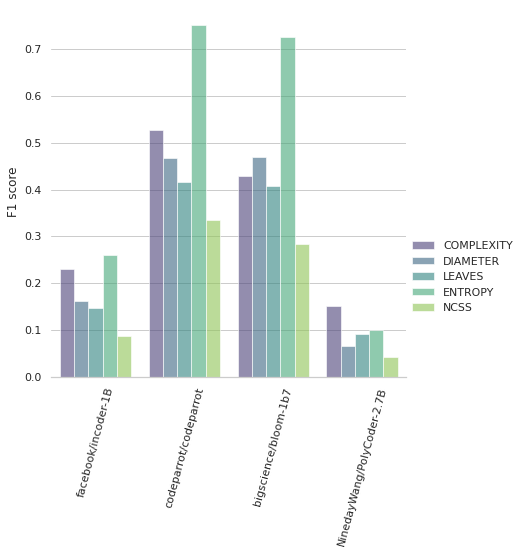

In [12]:
import seaborn as sns
sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=scores[scores.task_category!="DEPTH"], kind="bar",
    x="hf_model_name", y="f1_avg", hue="task_category",
    errorbar="sd", palette="viridis", alpha=.6, height=6
)
g.despine(left=True)
plt.xticks(rotation = 75) 
g.set_axis_labels("", "F1 score")
g.legend.set_title("")

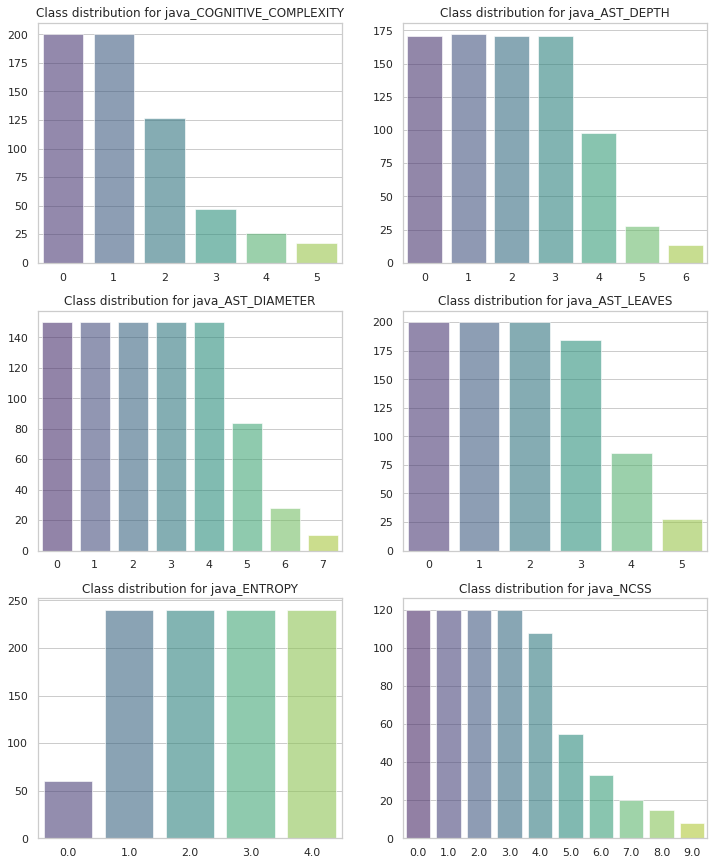

In [13]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(3,2, figsize=(12, 15))
# Draw a nested barplot by species and sex


vals, num = list(zip(*scores["ratio"][0]))
g = sns.barplot(ax=ax[0,0], x=np.array(list(map(int,vals))), y=np.array(num),  errorbar="sd", palette="viridis", alpha=.6)
ax[0,0].set_title(f"Class distribution for {scores['probing_task'][0]}")

vals, num = list(zip(*scores["ratio"][1]))
g = sns.barplot(ax=ax[0,1], x=np.array(list(map(int,vals))), y=np.array(num),  errorbar="sd", palette="viridis", alpha=.6)
ax[0,1].set_title(f"Class distribution for {scores['probing_task'][1]}")

vals, num = list(zip(*scores["ratio"][2]))
g = sns.barplot(ax=ax[1,0], x=np.array(list(map(int,vals))), y=np.array(num),  errorbar="sd", palette="viridis", alpha=.6)
ax[1,0].set_title(f"Class distribution for {scores['probing_task'][2]}")

vals, num = list(zip(*scores["ratio"][3]))
g = sns.barplot(ax=ax[1,1], x=np.array(list(map(int,vals))), y=np.array(num),  errorbar="sd", palette="viridis", alpha=.6)
ax[1,1].set_title(f"Class distribution for {scores['probing_task'][3]}")

vals, num = list(zip(*scores["ratio"][4]))
g = sns.barplot(ax=ax[2,0], x=np.array(list(map(float,vals))), y=np.array(num),  errorbar="sd", palette="viridis", alpha=.6)
ax[2,0].set_title(f"Class distribution for {scores['probing_task'][4]}")

vals, num = list(zip(*scores["ratio"][5]))
g = sns.barplot(ax=ax[2,1], x=np.array(list(map(float,vals))), y=np.array(num),  errorbar="sd", palette="viridis", alpha=.6)
ax[2,1].set_title(f"Class distribution for {scores['probing_task'][5]}")

plt.show()

#values, num = list(zip(*scores[scores.task_category=="LEAVES"].iloc[0].ratio))
#ax[0,0].bar(list(map(int,values)), num)
#ax[0,0].set_title("Number of labels for AST_LEAVES")


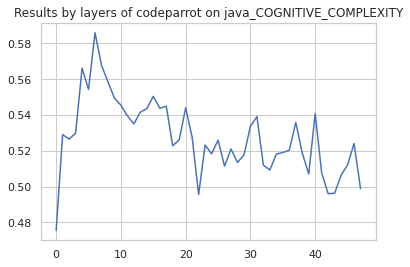

In [14]:
linenum = 6
plt.plot(scores.iloc[linenum].f1)
probing_task = "COGNITIVE_COMPLEXITY"
plt.title(f"Results by layers of {scores.iloc[linenum].hf_model_name.split('/')[1]} on {scores.iloc[linenum].probing_task}")
plt.show()